# Floating Marine Debris

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

## Floating Algae Index 


\begin{equation}
\text{FAI} = (R_{rs,NIR} - R_{rs, RED}) + (R_{rs, RED} - R_{rs, SWIR}) * \frac{(\lambda_{NIR} - \lambda_{RED})}{(\lambda_{SWIR} - \lambda_{RED})}
\end{equation}

where $R_{rs,NIR}$, $R_{rs, RED}$, $R_{rs, SWIR}$ are the reflectance values in the near infrared, red and short wave infrared bands, respectively, $λ_i$ are the wavelength with subscript band name. 

## Floating Debris Index (FDI) 

\begin{equation}
\text{FDI} = R_{rs,NIR} - (R_{rs, RE2} + (R_{rs, SWIR1} - R_{rs, RE2}) * \frac{(\lambda_{NIR} - \lambda_{RED})}{(\lambda_{SWIR1} - \lambda_{RED})} * 10)
\end{equation}


where $R_{rs,NIR}$, $R_{rs, RE2}$, $R_{rs, SWIR1}$ are the reflectance values in the near infrared, red edge 2, and
short-wave infrared bands, respectively, $λ_i$ are the wavelength with subscript band name. 


>Note wavelength values are the central wavelengths from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2


## Plastic Index

\begin{equation}
\text{Plastic Index} =  \frac{R_{rs,NIR}}{ R_{rs,NIR} +  R_{rs,RED}} 
\end{equation}

In [1]:
# Load the necessary python packages. 
%matplotlib inline
import os
import datacube

from datetime import datetime, timedelta
from matplotlib import colors as mcolors
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from datacube.utils.geometry import Geometry
from datacube.utils.cog import write_cog

from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard, wofs_fuser, mostcommon_crs
from deafrica_tools.spatial import xr_rasterize

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Connect the datacube.
dc = datacube.Datacube(app='Floating Marine Debris')

In [3]:
# Define the analysis parametres.

country = "south_africa"
#country = "ghana"

# File path for the area of interest to load Sentinel-2 imagery for.
aoi_fp = f"data/{country}_boundary_box.geojson"

# File path to the Floating Marine Debris Dataset. 
marine_debris_fp = f"data/floating_marine_debris_{country}.geojson"

# Statistic to use to sample the Sentinel-2 imagery.
stats = "mean"

output_crs = "EPSG:6933"
resolution = (-10, 10)

s2_measurements = ['red','red_edge_2', 'nir', 'swir_1']

s2_aliases = {'B4': 'red',
              'B6': 'red_edge_2',
              'B8': 'nir',
              'B11': 'swir_1'}


# Function to normalize the band values. 
def normalize_intensity(ds):
    bands = list(ds.data_vars)
    for band in bands:
        ds[band] = (ds[band] - ds[band].min()) / (ds[band].max() - ds[band].min())
    return ds


# Function to calculate the FAI, FDI and PI indices.
def insert_indices(ds):
    wavelength_nir = 842 * 1e-9
    wavelength_red = 665 * 1e-9
    wavelength_swir1 = 1610 * 1e-9
    
    # Floating Algae Index
    ds["FAI"] = (ds.nir - ds.red) + (ds.red - ds.swir_1) * (( wavelength_nir - wavelength_red) / (wavelength_swir1 - wavelength_red))
    
    # Floating Debris Index
    ds["FDI"] = ds.nir - (ds.red_edge_2 + (ds.swir_1 - ds.red_edge_2) * ((wavelength_nir - wavelength_red) / (wavelength_swir1 - wavelength_red)) * 10)
    
    # Plastic Index (PI)
    ds['PI'] = ds['nir'] / (ds['nir'] + ds['red'])
    
    return ds


# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)


# Define the color map to use when plotting. 
cmap = plt.get_cmap('tab20', 20)
color_list = [mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

In [4]:
# Load the area of interest.
aoi_gdf = gpd.read_file(aoi_fp)

# Convert the area of interest GeoDataFrame to a Geometry object.
geopolygon = Geometry(geom=aoi_gdf.iloc[0].geometry, crs=aoi_gdf.crs)

# Reproject the area of interest to the output_crs.
aoi_gdf = aoi_gdf.to_crs(output_crs)

In [5]:
# Load the Floating Marine Debris Dataset.
marine_debris_dataset = gpd.read_file(marine_debris_fp)

# Rename the columns.
marine_debris_dataset.rename(columns=s2_aliases, inplace=True)

# Reproject the marine_debris_dataset GeoDataFrame to the output crs.
marine_debris_dataset = marine_debris_dataset.to_crs(output_crs)

marine_debris_dataset.head()

,Location,Date,Sentinel-2,X,Y,Longitude,Latitude,B1,B2,B3,...,red_edge_2,B7,nir,B8A,swir_1,B12,NDVI,FDI,label,geometry
0,Durban,20190424,B,604,695,31.067331,-29.862928,0.046583,0.057195,0.071129,...,0.026071,0.035277,0.046596,0.035042,0.017558,0.013123,0.045525,0.035652,2,POINT (2997571.236 -3643584.334)
1,Durban,20190424,B,602,696,31.067123,-29.863016,0.051059,0.061052,0.073203,...,0.042515,0.045662,0.054454,0.052871,0.022846,0.016322,0.040072,0.046891,2,POINT (2997551.176 -3643594.073)
2,Durban,20190424,B,603,696,31.067226,-29.863018,0.051080,0.059210,0.071925,...,0.042530,0.045677,0.052702,0.052885,0.022857,0.016328,0.045425,0.045132,2,POINT (2997561.114 -3643594.285)
3,Durban,20190424,B,601,697,31.067019,-29.863106,0.051040,0.059683,0.073028,...,0.036088,0.048152,0.052812,0.044256,0.022368,0.015701,0.026340,0.041106,2,POINT (2997541.054 -3643604.024)
4,Durban,20190424,B,602,697,31.067122,-29.863106,0.051061,0.063926,0.076440,...,0.036103,0.036440,0.074385,0.048701,0.021199,0.016077,0.126258,0.064766,2,POINT (2997550.992 -3643604.024)


In [6]:
# Get the time range for which to load the Sentinel-2 imagery.
time = datetime.strptime(str(np.unique(marine_debris_dataset["Date"]).item()), '%Y%m%d')

delta_days = 15 
start_date = time - timedelta(days=delta_days)
end_date = time + timedelta(days=delta_days)

time_range = (start_date.strftime("%Y-%m-%d") , end_date.strftime("%Y-%m-%d"))

print(time)
print(time_range)

2019-04-24 00:00:00
('2019-04-09', '2019-05-09')


In [7]:
# Create a reusable datacube query.
query = dict(measurements=s2_measurements,
             geopolygon=geopolygon,
             time=time_range,
             resolution=resolution,
             output_crs=output_crs,
             group_by="solar_day")

In [8]:
# Load Sentinel-2 data using loard ard.
ds_s2_ard = load_ard(dc=dc,
                     products=["s2_l2a"],
                     dtype='native',
                     #min_gooddata=0.9
                     **query
                    )

# Mask the Sentinel 2 dataset to the area of interest.
mask = xr_rasterize(aoi_gdf, ds_s2_ard)
ds_s2_ard = ds_s2_ard.where(mask)

# Normalize the bands.
ds_s2_ard = normalize_intensity(ds_s2_ard)

# Calculate the required spectral indices.
ds_s2_ard =  insert_indices(ds_s2_ard)

print(ds_s2_ard)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 7 time steps


/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:      (time: 7, y: 4517, x: 3585)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-09T08:08:49 ... 2019-05-09T08:...
  * y            (y) float64 -3.61e+06 -3.61e+06 ... -3.655e+06 -3.655e+06
  * x            (x) float64 2.993e+06 2.993e+06 ... 3.029e+06 3.029e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    red_edge_2   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FAI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FDI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    PI           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [9]:
affine = ds_s2_ard.geobox.affine
crs = ds_s2_ard.geobox.crs

In [10]:
# Sample the Sentinel-2 ARD dataset using the points from the floating marine debris dataset.

# Extract the geometry of the marine_debris_dataset to create a new GeoDataFrame.
gdf =  gpd.GeoDataFrame(geometry=gpd.GeoSeries(marine_debris_dataset["geometry"])) 

# Get the time steps available for the Sentinel-2 ARD dataset. 
time_steps = ds_s2_ard.time.values
# Get the Sentinel-2 bands to sample.
bands = ["red_edge_2", "FDI"]

for time_step in time_steps:
    ds = ds_s2_ard.sel(time=time_step).squeeze()
    time = np.datetime_as_string(time_step, unit='D')
    # Write the dataset to a GeoTIFF
    #write_cog(ds.to_array(),
    #          fname=f"results/{country}_s2_ard_{time}.tif",
    #          overwrite=True)
    for band in bands:
        statistics = zonal_stats(gdf, ds[band].values, affine=affine, stats=[stats], nodata=np.nan)
        gdf[f"s2_ard_{band}_{time}"] = [i[stats] for i in statistics]

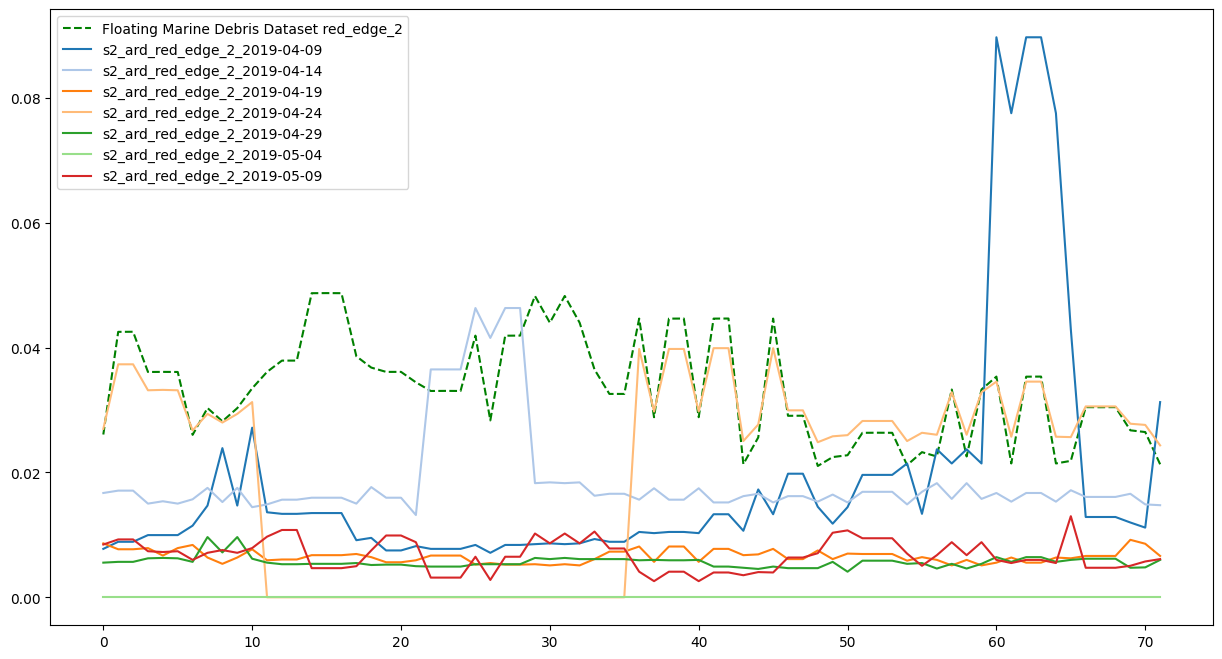

In [11]:
# Compare the red edge 2 values from the Floating Marine Dataset 
# to the values from the Sentinel-2 datasets.

column = "red_edge_2"
columns = [i for i in list(gdf.columns) if column in i]

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset[column].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    gdf[col].plot(ax=ax, color=color_list[index])

plt.legend()

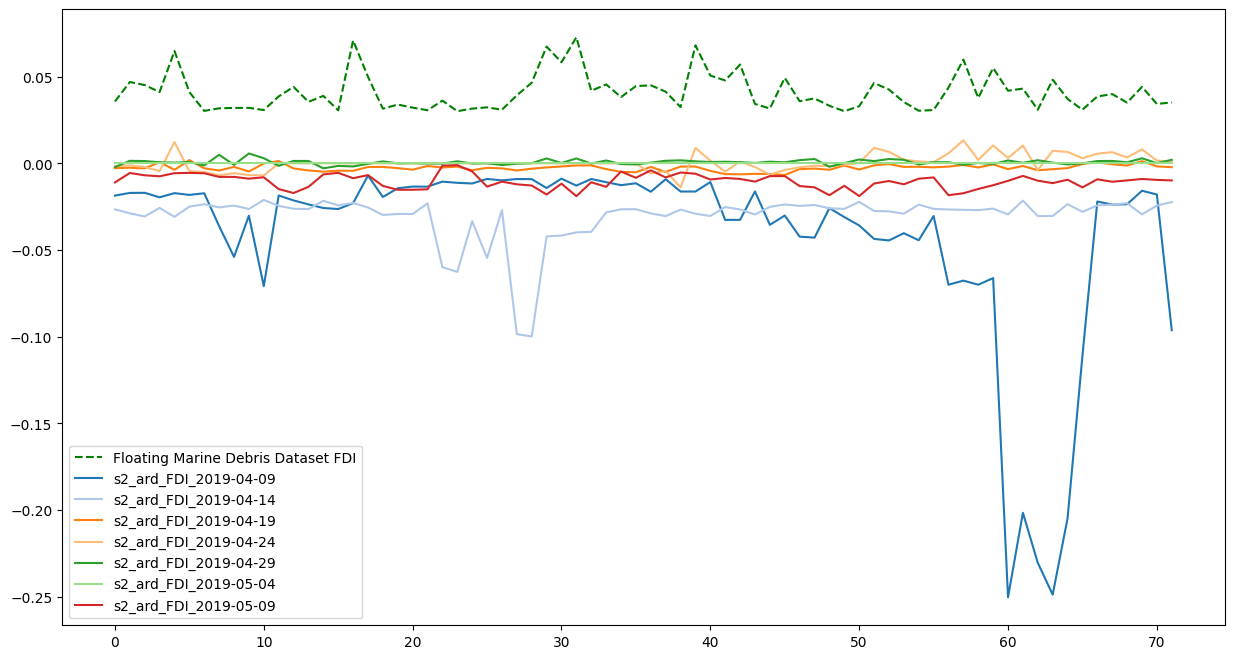

In [12]:
# Compare the FDI values from the Floating Marine Dataset 
# to the values from the Sentinel-2 dataset.

column = "FDI"
columns = [i for i in list(gdf.columns) if column in i]

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset[column].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    gdf[col].plot(ax=ax, color=color_list[index])

plt.legend()

In [13]:
# Load Sentinel-2 data using 'dc.load'.
ds_s2 = dc.load(product=["s2_l2a"],
                **query
                )

# Mask the Sentinel 2 dataset to the area of interest. 
mask = xr_rasterize(aoi_gdf, ds_s2)
ds_s2 = ds_s2.where(mask)

# Normalize the bands.
ds_s2 = normalize_intensity(ds_s2)

# Calculate the required spectral indices.
ds_s2 =  insert_indices(ds_s2)

print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 7, y: 4517, x: 3585)
Coordinates:
  * time         (time) datetime64[ns] 2019-04-09T08:08:49 ... 2019-05-09T08:...
  * y            (y) float64 -3.61e+06 -3.61e+06 ... -3.655e+06 -3.655e+06
  * x            (x) float64 2.993e+06 2.993e+06 ... 3.029e+06 3.029e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    red_edge_2   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FAI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FDI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    PI           (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [14]:
affine = ds_s2.geobox.affine
crs = ds_s2.geobox.crs

In [15]:
# Sample the Sentinel-2 dataset using the points from the floating marine debris dataset.

# Extract the geometry of the marine_debris_dataset to create a new GeoDataFrame.
gdf2 =  gpd.GeoDataFrame(geometry=gpd.GeoSeries(marine_debris_dataset["geometry"])) 

# Get the time steps available for the Sentinel-2 dataset. 
time_steps = ds_s2.time.values
# Get the Sentinel-2 bands to sample.
bands = ["red_edge_2", "FDI"]

for time_step in time_steps:
    ds = ds_s2.sel(time=time_step).squeeze()
    time = np.datetime_as_string(time_step, unit='D')
    # Write the dataset to a GeoTIFF
    #write_cog(ds.to_array(),
    #          fname=f"results/{country}_s2_{time}.tif",
    #          overwrite=True)
    for band in bands:
        statistics = zonal_stats(gdf, ds[band].values, affine=affine, stats=[stats], nodata=np.nan)
        gdf2[f"s2_{band}_{time}"] = [i[stats] for i in statistics]

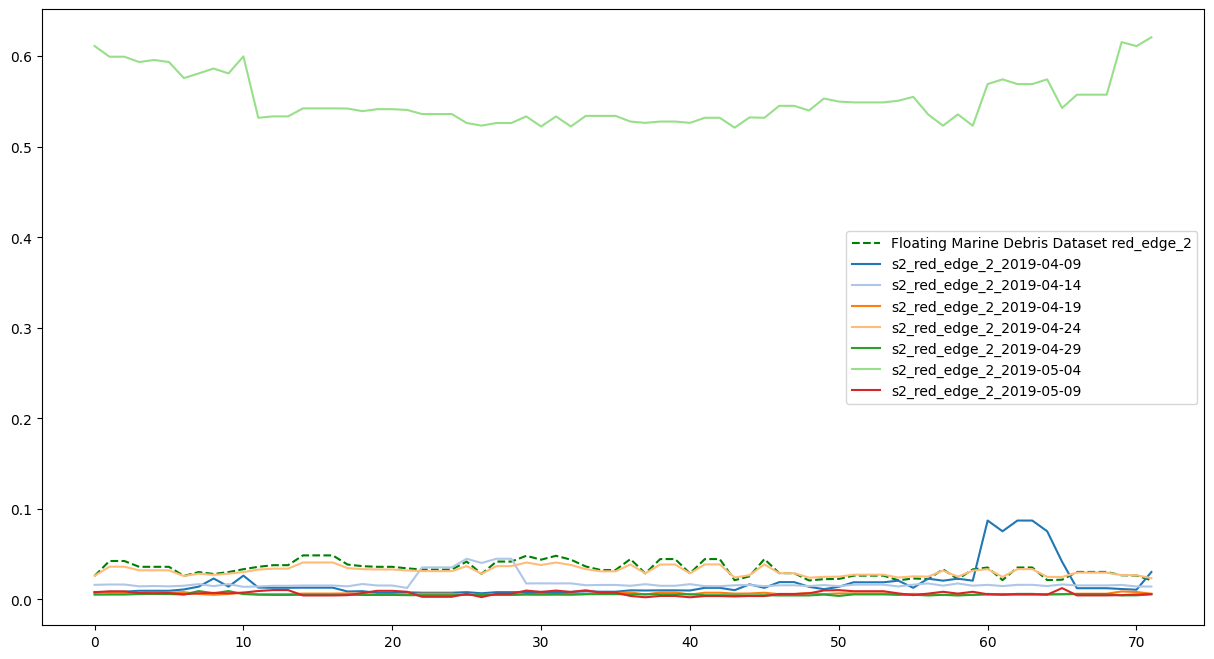

In [16]:
# Compare the red edge 2 values from the Floating Marine Dataset 
# to the values from the Sentinel-2 dataset.

column = "red_edge_2"
columns = [i for i in list(gdf2.columns) if column in i]

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset[column].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    gdf2[col].plot(ax=ax, color=color_list[index])

plt.legend()

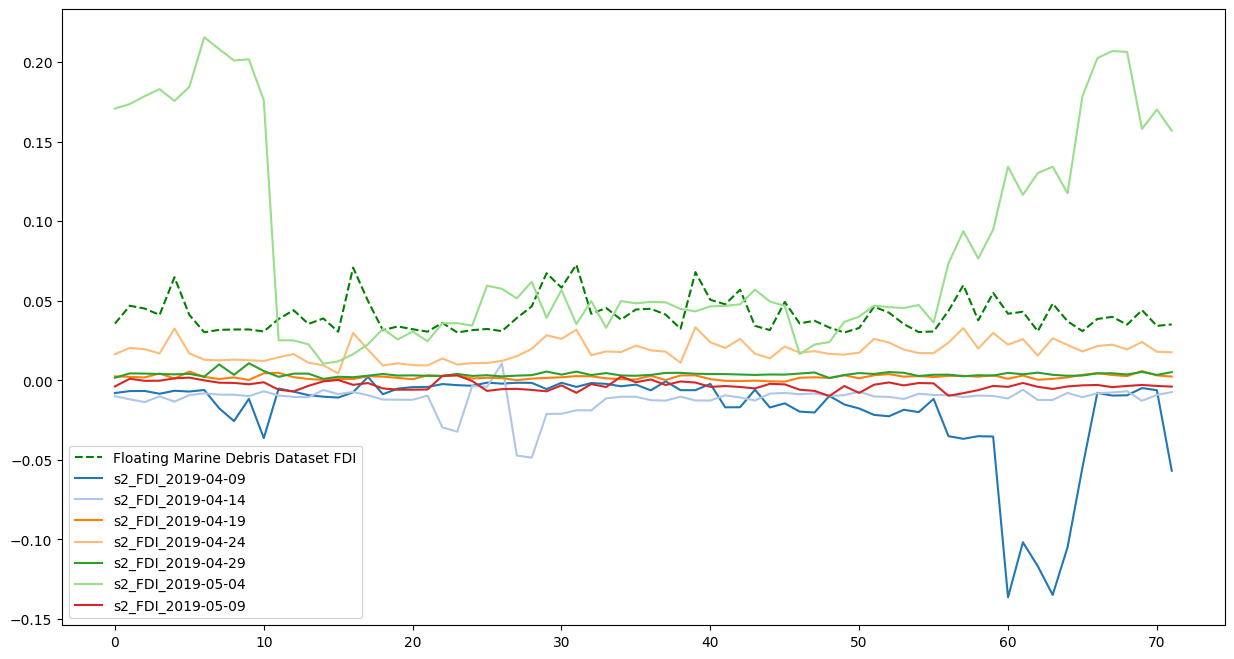

In [17]:
# Compare the FDI values from the Floating Marine# Compare the FDI values from the Floating Marine Dataset 
# to the values from the Sentinel-2 dataset.

column = "FDI"
columns = [i for i in list(gdf2.columns) if column in i]

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset[column].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset {column}")

for index, col in enumerate(columns):
    gdf2[col].plot(ax=ax, color=color_list[index])

plt.legend()

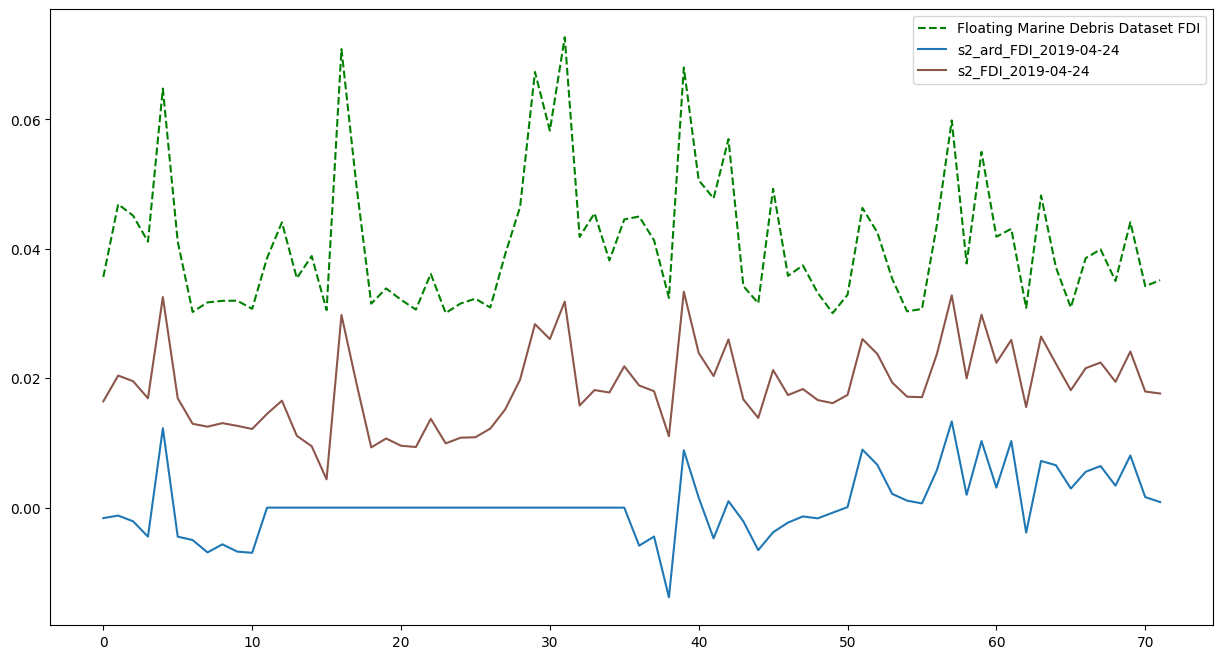

In [18]:
# Plot the Sentinel-2 dates that matches the Floating Dataset Debris FDI values the most. 

fig, ax = plt.subplots(figsize=(15,8))

marine_debris_dataset["FDI"].plot(ax=ax, style='g--', label=f"Floating Marine Debris Dataset FDI")

gdf['s2_ard_FDI_2019-04-24'].plot(ax=ax, color=color_list[0])

gdf2['s2_FDI_2019-04-24'].plot(ax=ax, color=color_list[10])

plt.legend()